In [5]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import NullLocator
import matplotlib.colors as colors
from scipy import spatial
import SimpleITK as sitk
from sklearn import metrics 
from skimage import morphology, measure
from tqdm import tqdm

In [33]:
def tumor_splitser(segmentation, remove_fist_component = True):
    '''
    takes in segmentation of multiple conected components and splits them over images with only one component 
    takes np.array as input
    returns np.array dims=(z,y,x,components)
    '''
    if isinstance(segmentation, sitk.Image):
        segmentation = sitk.GetArrayFromImage(segmentation)
    
    segmentation = measure.label(segmentation)
    # print('max',np.max(segmentation))
    out = np.empty((segmentation.shape[0], segmentation.shape[1], segmentation.shape[2], np.max(segmentation)))

    
    for i in range(1, np.max(segmentation)+1):
        # print('i',i)
        split = np.zeros_like(segmentation, dtype = np.bool_)
        split[np.where(segmentation == i)] = True
        out[:,:,:,i-1] = split
        
    return out

def run_dice(segmentation_folder, gt_folder):
    '''
    Runs dice score over all components in segmentation and gt
    returns list of non-zero dice scores
    '''
    teller = 0
    dice_scores = []
    # loop over all files in segmentation folder
    for i in tqdm(os.listdir(segmentation_folder)):
        
        if i.endswith('.nii'):
            # load images
            segmentation = sitk.ReadImage(os.path.join(segmentation_folder, i))
            gt = sitk.ReadImage(gt_folder+i[0:8]+'_0000.nii.gz')
            
            # split connected components
            segmentation = tumor_splitser(segmentation)
            gt = tumor_splitser(gt)

            # loop over all components in segmentation
            for j in range(1,segmentation.shape[3]):    
                for k in range(0,gt.shape[3]):
                    
                    dice_score = metrics.f1_score(segmentation[:,:,:,j].flatten(), gt[:,:,:,k].flatten())
                
                    if dice_score != 0:
                        dice_scores.append(dice_score)
                              
    return dice_scores

In [34]:
ls


 Volume in drive C is OSDisk
 Volume Serial Number is 5C34-AC20

 Directory of C:\Users\092335\PycharmProjects\MEP2\segmentation\nnUNet

14-12-2022  07:41 PM    <DIR>          .
14-12-2022  07:41 PM    <DIR>          ..
14-12-2022  04:42 PM    <DIR>          .ipynb_checkpoints
14-12-2022  07:41 PM             6,640 eval.ipynb
14-12-2022  04:20 PM            11,785 nnUnet_dataformat_converter.ipynb
14-12-2022  04:32 PM         1,355,798 segment_eval.ipynb
               3 File(s)      1,374,223 bytes
               3 Dir(s)  92,326,240,256 bytes free


In [37]:
data_root = '//storage.erasmusmc.nl/m/MyDocs/092335/My Documents/Desktop/Data' 
gt_root = data_root + '/nnUnet/pure_CRLM/task502_CRLM/'

segmentation_folder = '//storage.erasmusmc.nl/m/MyDocs/092335/My Documents/Desktop/Data/WORC_CRLM/Pure_CRLM_data/predictions' 

gt_RAD  = data_root + '/nnUnet/pure_CRLM/task502_CRLM/labelsTr/' #(RAD)
gt_STUD1 = gt_root + 'labelsTr_STUD1/'
gt_STUD2 = gt_root + 'labelsTr_STUD2/'
gt_CNN  = gt_root + 'labelsTr_CNN/'
gt_PhD  = gt_root + 'labelsTr_PhD/'

gt_RAD_dice   = run_dice(segmentation_folder, gt_RAD)
gt_STUD1_dice = run_dice(segmentation_folder, gt_STUD1)
gt_STUD2_dice = run_dice(segmentation_folder, gt_STUD2)
gt_CNN_dice = run_dice(segmentation_folder,   gt_CNN)
gt_PhD_dice = run_dice(segmentation_folder,   gt_PhD)

['CRLM_001_0000.nii.gz', 'CRLM_002_0000.nii.gz', 'CRLM_003_0000.nii.gz', 'CRLM_004_0000.nii.gz', 'CRLM_005_0000.nii.gz', 'CRLM_006_0000.nii.gz', 'CRLM_007_0000.nii.gz', 'CRLM_008_0000.nii.gz', 'CRLM_009_0000.nii.gz', 'CRLM_010_0000.nii.gz', 'CRLM_011_0000.nii.gz', 'CRLM_012_0000.nii.gz', 'CRLM_013_0000.nii.gz', 'CRLM_014_0000.nii.gz', 'CRLM_015_0000.nii.gz', 'CRLM_016_0000.nii.gz', 'CRLM_017_0000.nii.gz', 'CRLM_018_0000.nii.gz', 'CRLM_019_0000.nii.gz', 'CRLM_020_0000.nii.gz', 'CRLM_021_0000.nii.gz', 'CRLM_022_0000.nii.gz', 'CRLM_023_0000.nii.gz', 'CRLM_024_0000.nii.gz', 'CRLM_025_0000.nii.gz', 'CRLM_026_0000.nii.gz', 'CRLM_027_0000.nii.gz', 'CRLM_028_0000.nii.gz', 'CRLM_029_0000.nii.gz', 'CRLM_030_0000.nii.gz', 'CRLM_031_0000.nii.gz', 'CRLM_032_0000.nii.gz', 'CRLM_033_0000.nii.gz', 'CRLM_034_0000.nii.gz', 'CRLM_035_0000.nii.gz', 'CRLM_036_0000.nii.gz', 'CRLM_037_0000.nii.gz', 'CRLM_038_0000.nii.gz', 'CRLM_039_0000.nii.gz', 'CRLM_040_0000.nii.gz', 'CRLM_041_0000.nii.gz', 'CRLM_042_0000.

100%|██████████| 34/34 [42:46<00:00, 75.49s/it]  


In [39]:
root = data_root + '/WORC_CRLM/Pure_CRLM_data/nnUNet_dice_reults/'

np.save(root + 'dice_scores.npy', gt_RAD_dice)
np.save(root + 'gt_STUD1_dice.npy', gt_STUD1_dice)
np.save(root + 'gt_STUD2_dice.npy', gt_STUD2_dice)
np.save(root + 'gt_CNN_dice.npy', gt_CNN_dice)
np.save(root + 'gt_PhD_dice.npy', gt_PhD_dice)

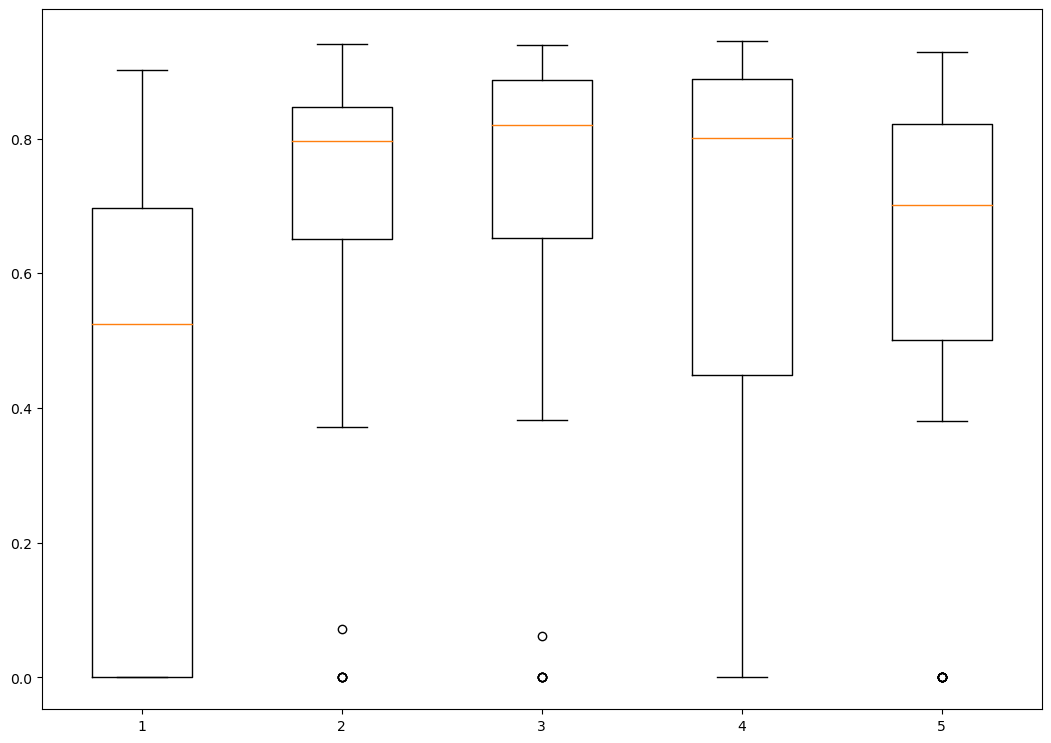

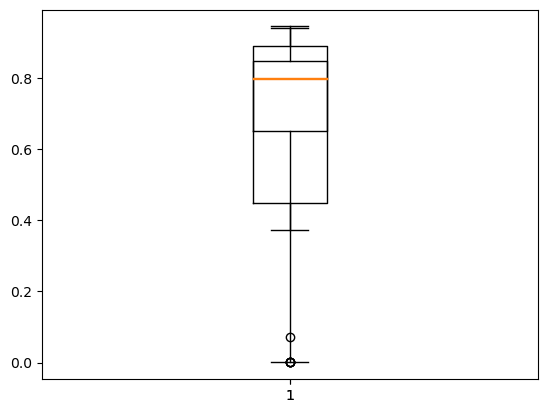

In [44]:
data = [gt_RAD_dice, gt_STUD1_dice, gt_STUD2_dice, gt_CNN_dice, gt_PhD_dice]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
